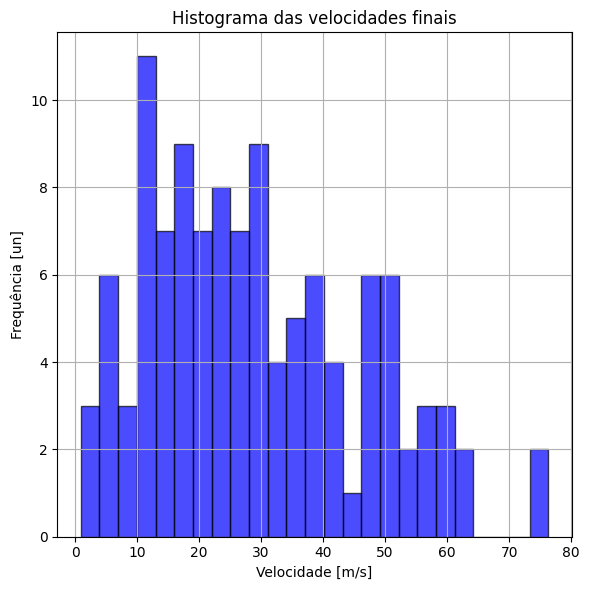

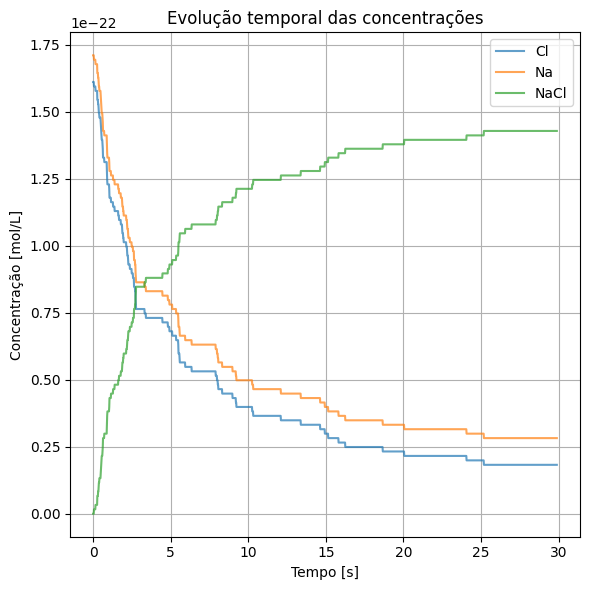

Variável independente_1: ['x']
Parâmetros modelo_1: ['exp_1_amplitude', 'exp_1_decay']

Variável independente_2: ['x']
Parâmetros modelo_2: ['exp_2_amplitude', 'exp_2_decay']
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
exp_1_amplitude     53.65     -inf      inf     None     True     None     None
exp_1_decay         15.69     -inf      inf     None     True     None     None

Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
exp_2_amplitude     58.23     -inf      inf     None     True     None     None
exp_2_decay         19.84     -inf      inf     None     True     None     None
[[Model]]
    Model(exponential, prefix='exp_1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1793
    # variables        = 2
    chi-square         = 53641.1452
    reduced chi-square = 29.9503882
    Akaike info crit   = 6097.37820
    Bayesian info crit = 6108.36149
    R-squ

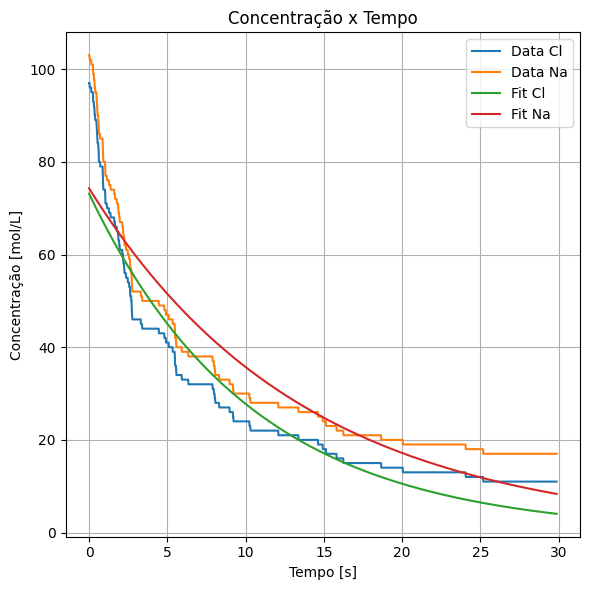

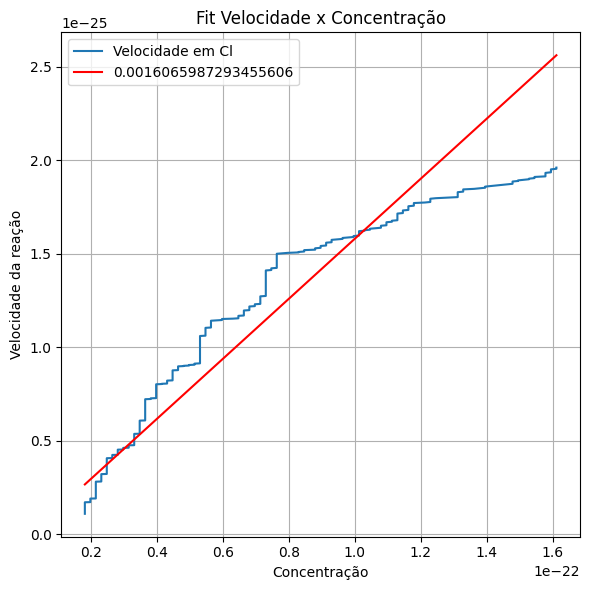

SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
#Debugging 16-10-2023 == FALSE_V1; LATEST STABLE == V1
#UI == pygame
#Implementado gráfico Max-Boltz
#Implementação do fit da Lei de Velocidade
#'future' funciona (inherited 6_10)
#Colisão inelástica e elástica implementada
#Colisão futura implementada em classe Particul
#Reação química feita + grafico conc./tempo
#Fazer: encontrar a lei de velocidade (derivadas)
#Problemas: 
# -não é vetorializado
# -baixa eficiência por itertools
# -NA_CL_INDEX como global
# -a = 'Na', b = 'Cl'; a = 'Cl', b = 'Na'-> e se forem 3?
# -intersection_position_checker que nao precisa checar tudo ?
# -reações que geram partículas grandes podem gerar intersecção com outra que está indo em direção a esta

#Vetorialização:
#Usar arrays; mínimo de for's e while's (loops); numpy; scipy cdist; numpy.greater

import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import ExponentialModel, LinearModel
from lmfit import Model, Parameters
import itertools

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 500
LARGURA_CAIXA = 500
NUM_PARTICULAS = 200
#GRID_SIZE = 10
FUTURE_FACTOR = 2
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

AVOGADRO_CONSTANT = 6.022e23 #constante de avogadro

NAME_BOLTZ = 'max-boltz_6_16.png'
NAME_CONCENTRATION_PLOT = 'concentration_6_16.png'
NAME_FIT_CONCENTRATION_PLOT = 'fit_concentration_6_16.png'
NAME_VEL_RATE = 'velocidade_reacao_6_16.png'
NAME_CHEMICAL_CSV = 'df_chemical_data_6_16.csv'
NAME_MOLARITY_CSV = 'df_molarity_data_6_16.csv'

# Indexes de moléculas das reações
NA_CL_INDEX = 0
CHANCE_NACL_GLOBAL = 0.4 #chances de não acontecer a reação

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, massa, raio, vel_x, vel_y, x, y, cor):
        self.p_type = p_type
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = None
        self.y_future = None
        self.cor = cor
        self.sprite_pygame = self.sprite_pygame()

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

        if self.x_future < self.raio or self.x_future > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y_future < self.raio or self.y_future > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

        #print('next_position')

    def sprite_pygame(self):
        circle = pygame.Surface((self.raio * 2, self.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, self.cor, (self.raio, self.raio), self.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(self.x, self.y))
        return sprite

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = np.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    #distance = np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if (distance_future <= p1.raio + p2.raio) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index, sprites):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    chance_NaCl_local = random.random() #chanc de acontecer a reação

    #print('arrays_reaction_CM:', CM_x, CM_y )

    #new_particles = particles.copy()
    #print('old_particles:', particles)


    if ((p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na')) and (chance_NaCl_local > CHANCE_NACL_GLOBAL):
        #print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        massa = (p1.massa + p2.massa)
        raio = 5
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)

        sprites.add(particle_instance.sprite_pygame)
        
        NA_CL_INDEX += 1

        particles.update({nome_particula : particle_instance})
        particles.pop(p1_index)
        particles.pop(p2_index)

        p1.sprite_pygame.kill()
        p2.sprite_pygame.kill()


    else:
        #print('does not react')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)

    #print('new_particles:',particles)
    #print()
    return particles


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    #print('resolution',p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula




def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 5, "color": (255, 0, 0)}, #approximations
        "Cl": {"massa": 35, "raio": 5, "color": (0, 255, 0)},

    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-60, 60) #velocidade inicial não especificada
        vel_y = random.uniform(-60, 60)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance

    return particulas

def select_particles(particles,sprites):
    particles_update = set()
    particles_remove = []

    #print('entrou pra selected')

    # particle_pairs = np.array(list(itertools.combinations(particles.items(), 2)))
    #print('pares',particle_pairs)

    for (name_p1, instance_p1), (name_p2, instance_p2) in itertools.combinations(particles.items(), 2):
        #print((name_p1, type(instance_p1)), (name_p2, type(instance_p2)))
        if check_collision(instance_p1, instance_p2):
            #print('foi pra reacted')
            reacted_particles = reaction_collision(particles, instance_p1, name_p1, instance_p2, name_p2,sprites)
            

            if particles != reacted_particles:
                particles_update.update(reacted_particles)
                particles_remove.extend([name_p1, name_p2])

    for particle_name in particles_remove:
        del particles[particle_name]

    particles.update(particles_update)

    return particles



def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    #particle_pairs = np.array(list(itertools.permutations(particles.items(), 2)))
    for (name_p1, instance_p1), (name_p2, instance_p2) in itertools.combinations(particles.items(), 2):
        if check_collision(instance_p1, instance_p2):
                particle_move = random.choice([[name_p1,instance_p1], [name_p2,instance_p2]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_group_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        sprite = particle_instance.sprite_pygame
        sprites.add(sprite)
    #print(sprites)
    return sprites


def chemical_counter(particles,time_passed,df=pd.DataFrame()):

    chem_list = particles.keys()
    #n_moleculas = len(chem_list)

    element_count = {}  # Initialize an empty dictionary to store element counts

    for item in chem_list:
        element = item.split('_')[0]  # Extract the element (part before the underscore)
        if element in element_count:
            element_count[element] += 1  # Increment the count if the element already exists
        else:
            element_count[element] = 1  # Initialize count to 1 if the element is encountered for the first time


    #df_chem_columns = np.append('Tempo',list(element_count.keys()))
    #print(df_chem_columns)
    chem_array = np.append(time_passed,list(element_count.values()))
    #print(chem_array)
    df_chem = pd.DataFrame(chem_array).T
    df_chem.columns = np.append('Tempo',list(element_count.keys()))

    df_chem = pd.concat([df, df_chem], axis=0, ignore_index=True)

    return df_chem


def convert_to_molarity(df,liter):
    df_molar = df.copy()
    for column in range(1,df_molar.shape[1]):
        #print(column)
        df_molar.iloc[:,column] = ((df_molar.iloc[:,column]/AVOGADRO_CONSTANT)/liter)
    return df_molar


def fit_concentration_plot(df,name,sup_lim=-1):
    x_data = df.iloc[0:sup_lim,0].values

    y1_data = df.iloc[0:sup_lim,1].values #Cl
    y2_data = df.iloc[0:sup_lim,2].values #Na
    #print(len(y1_data),len(y2_data))

    modelo_exponencial_1 = ExponentialModel(prefix = 'exp_1_')
    modelo_exponencial_2 = ExponentialModel(prefix = 'exp_2_')
    print(f'Variável independente_1: {modelo_exponencial_1.independent_vars}')
    print(f'Parâmetros modelo_1: {modelo_exponencial_1.param_names}')
    print()
    print(f'Variável independente_2: {modelo_exponencial_2.independent_vars}')
    print(f'Parâmetros modelo_2: {modelo_exponencial_2.param_names}')

    params_exponencial_1 = modelo_exponencial_1.guess(y1_data,x=x_data)
    params_exponencial_2 = modelo_exponencial_2.guess(y2_data,x=x_data)
    params_exponencial_1.pretty_print()
    print()
    params_exponencial_2.pretty_print()

    resultado_fit_1 = modelo_exponencial_1.fit(y1_data, params_exponencial_1, x=x_data)
    resultado_fit_2 = modelo_exponencial_2.fit(y2_data, params_exponencial_2, x=x_data)
    print(resultado_fit_1.fit_report())
    print()
    print(resultado_fit_2.fit_report())

    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    ax.plot(x_data, y1_data, label="Data Cl")
    ax.plot(x_data, y2_data, label="Data Na")
    ax.plot(x_data, resultado_fit_1.best_fit, label="Fit Cl")
    ax.plot(x_data, resultado_fit_2.best_fit, label="Fit Na")
    plt.title('Concentração x Tempo')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Concentração [mol/L]')
    plt.legend()
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()

    data_vel_fit = {'x_data' : x_data,'resultado_fit_1' : resultado_fit_1, 'resultado_fit_2' : resultado_fit_2, 'y1_data' : y1_data, 'y2_data' : y2_data}

    return data_vel_fit


def vel_rate_plot(data_vel_fit,name):
    #print(data_vel_fit['resultado_fit_1'])
    #print(data_vel_fit['resultado_fit_1'].best_fit)
    derivative = -np.diff(data_vel_fit['resultado_fit_1'].best_fit/AVOGADRO_CONSTANT/1,n=1)
    #print(derivative)
    concentrations = data_vel_fit['y1_data'][:-1]/AVOGADRO_CONSTANT/1


    model = LinearModel()

    # Create a Parameters object to store the parameter values
    params_linear = model.guess(derivative, x=concentrations)

    # Perform the fit
    result_linear = model.fit(derivative, params_linear, x=concentrations)

    slope_linear = result_linear.params['slope'].value
    intercept_linear = result_linear.params['intercept'].value


    fig2, ax2 = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    #ax2.plot(data_vel_fit['y1_data'], derivative_1, label = "Velocidade em Cl")
    ax2.plot(concentrations,derivative, label = "Velocidade em Cl")
    ax2.plot(concentrations, result_linear.best_fit, label=f"{slope_linear}", color='red')

    plt.title('Fit Velocidade x Concentração')
    plt.xlabel('Concentração')
    plt.ylabel('Velocidade da reação')
    plt.legend()
    plt.grid(True)
    fig2.tight_layout()
    fig2.savefig(name)  # Salva a figura
    plt.show()



def maxwell_boltzmann_plot(final_speeds,name):
    # Barplot/histograma das velocidades Max-Boltz.
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('Velocidade [m/s]')
    plt.ylabel('Frequência [un]')
    plt.title('Histograma das velocidades finais')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()


def concentration_plot(df,name):
    # Lineplot das concentrações/tempo.
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    for y_axis, labels in zip(df.columns[1:],list(df.columns)[1:]):
        plt.plot(df['Tempo'],df[y_axis]/AVOGADRO_CONSTANT/1,alpha=0.7, label=labels)
    plt.legend()
    plt.xlabel('Tempo [s]')
    plt.ylabel('Concentração [mol/L]')
    plt.title('Evolução temporal das concentrações')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()



def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_group_sprites(particles)

    #digito_atual = 0
    time_passed = 0
    df_chem = chemical_counter(particles, time_passed)

    #grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = np.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                maxwell_boltzmann_plot(final_speeds,name=NAME_BOLTZ) #desligado para debugging

                df_chem = df_chem.fillna(0)
                df_chem.to_csv(NAME_CHEMICAL_CSV, index=False)
                #df_chem_molarity = convert_to_molarity(df_chem,1)
                #df_chem_molarity.to_csv(NAME_MOLARITY_CSV, index=False)
                concentration_plot(df_chem,name=NAME_CONCENTRATION_PLOT)
                data_fit = fit_concentration_plot(df_chem,name=NAME_FIT_CONCENTRATION_PLOT)
                vel_rate_plot(data_fit,name=NAME_VEL_RATE)
                #print(df_chem_molarity)
                exit()

        time_passed += DT
        #primeiro_digito = int(time_passed)

        #if (digito_atual == 0) or (digito_atual != primeiro_digito):
         #   primeiro_digito = digito_atual
            #print('novo df_chem')
        df_chem = chemical_counter(particles,time_passed,df_chem)
            

        #print('after_reaction')
        particles = select_particles(particles,sprites)
        #print(type(after_reaction_particles))

        # Update particle positions after collision detection
        for particle_name, particle_instance in particles.items():
            particle_instance.deslocar()
            particle_instance.next_position() #usado para calcular if colisao == True
            #print('Debugger:',particle_instance.x, particle_instance.y, particle_instance.x_future, particle_instance.y_future)

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        #print(time_passed)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()


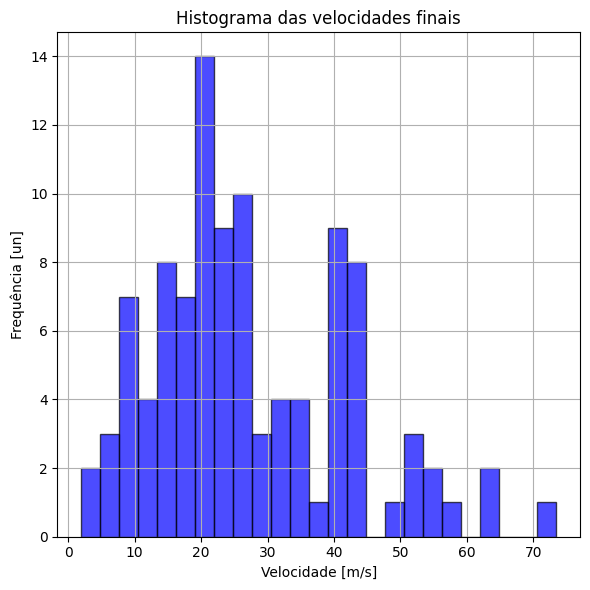

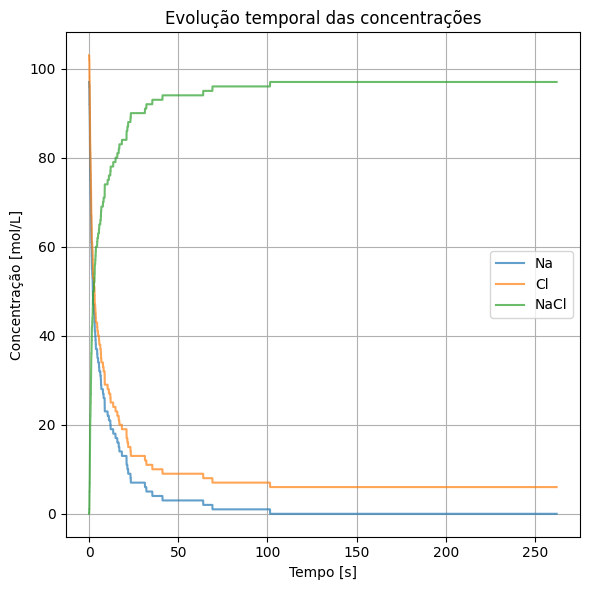

Variável independente_1: ['x']
Parâmetros modelo_1: ['exp_1_amplitude', 'exp_1_decay']

Variável independente_2: ['x']
Parâmetros modelo_2: ['exp_2_amplitude', 'exp_2_decay']
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
exp_1_amplitude     169.2     -inf      inf     None     True     None     None
exp_1_decay          5.08     -inf      inf     None     True     None     None

Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
exp_2_amplitude     13.71     -inf      inf     None     True     None     None
exp_2_decay         225.2     -inf      inf     None     True     None     None
[[Model]]
    Model(exponential, prefix='exp_1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 15727
    # variables        = 2
    chi-square         = 64780.7307
    reduced chi-square = 4.11960132
    Akaike info crit   = 22267.6006
    Bayesian info crit = 22282.9269
    R-sq

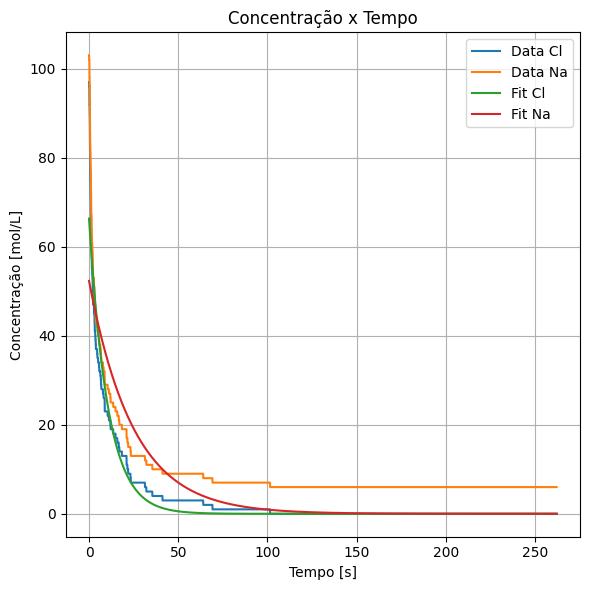

[[Model]]
    Model(quadratic_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 15726
    # variables        = 3
    chi-square         = 0.10420072
    reduced chi-square = 6.6273e-06
    Akaike info crit   = -187518.795
    Bayesian info crit = -187495.806
    R-squared          = 0.96769224
[[Variables]]
    a: -6.8916e-06 +/- 8.1837e-08 (1.19%) (init = 1)
    b:  0.00191146 +/- 4.9209e-06 (0.26%) (init = 1)
    c: -0.00116847 +/- 2.2609e-05 (1.93%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.8876
    C(b, c) = -0.3899
    C(a, c) = +0.2755


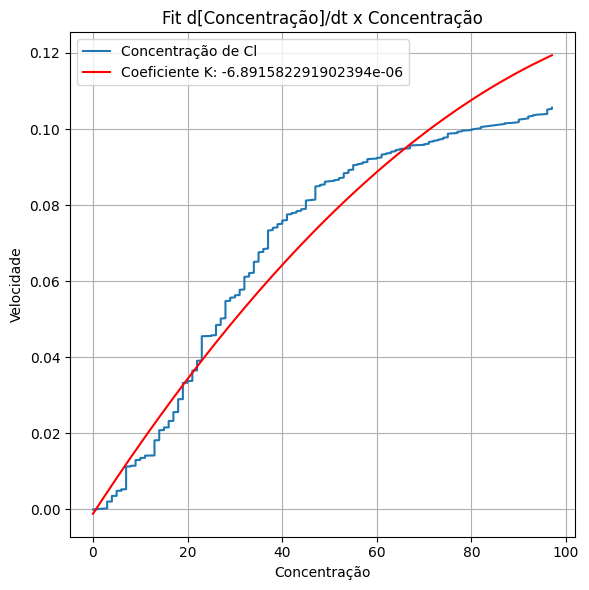

SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
#Debugging 16-10-2023 == FALSE_V1; LATEST STABLE == V1
#UI == pygame
#Implementado gráfico Max-Boltz
#Implementação do fit da Lei de Velocidade
#'future' funciona (inherited 6_10)
#Colisão inelástica e elástica implementada
#Colisão futura implementada em classe Particul
#Reação química feita + grafico conc./tempo
#Fazer: encontrar a lei de velocidade (derivadas)
#Problemas: 
# -não é vetorializado
# -baixa eficiência por itertools
# -NA_CL_INDEX como global
# -a = 'Na', b = 'Cl'; a = 'Cl', b = 'Na'-> e se forem 3?
# -intersection_position_checker que nao precisa checar tudo ?
# -reações que geram partículas grandes podem gerar intersecção com outra que está indo em direção a esta

#Vetorialização:
#Usar arrays; mínimo de for's e while's (loops); numpy; scipy cdist; numpy.greater

import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import ExponentialModel, LinearModel
from lmfit import Model, Parameters
import itertools

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 500
LARGURA_CAIXA = 500
NUM_PARTICULAS = 200
#GRID_SIZE = 10
FUTURE_FACTOR = 2
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

AVOGADRO_CONSTANT = 6.022e23 #constante de avogadro

NAME_BOLTZ = 'max-boltz_6_16.png'
NAME_CONCENTRATION_PLOT = 'concentration_6_16.png'
NAME_FIT_CONCENTRATION_PLOT = 'fit_concentration_6_16.png'
NAME_VEL_RATE = 'velocidade_reacao_6_16.png'
NAME_CHEMICAL_CSV = 'df_chemical_data_6_16.csv'
NAME_MOLARITY_CSV = 'df_molarity_data_6_16.csv'

# Indexes de moléculas das reações
NA_CL_INDEX = 0
CHANCE_NACL_GLOBAL = 0.4 #chances de não acontecer a reação

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, massa, raio, vel_x, vel_y, x, y, cor):
        self.p_type = p_type
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = None
        self.y_future = None
        self.cor = cor
        self.sprite_pygame = self.sprite_pygame()

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

        if self.x_future < self.raio or self.x_future > LARGURA_CAIXA - self.raio:
            self.vel_x *= -1
        if self.y_future < self.raio or self.y_future > ALTURA_CAIXA - self.raio:
            self.vel_y *= -1

        #print('next_position')

    def sprite_pygame(self):
        circle = pygame.Surface((self.raio * 2, self.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, self.cor, (self.raio, self.raio), self.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(self.x, self.y))
        return sprite

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = np.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    #distance = np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if (distance_future <= p1.raio + p2.raio) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index, sprites):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    chance_NaCl_local = random.random() #chanc de acontecer a reação

    #print('arrays_reaction_CM:', CM_x, CM_y )

    #new_particles = particles.copy()
    #print('old_particles:', particles)


    if ((p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na')) and (chance_NaCl_local > CHANCE_NACL_GLOBAL):
        #print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        massa = (p1.massa + p2.massa)
        raio = 5
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)

        sprites.add(particle_instance.sprite_pygame)
        
        NA_CL_INDEX += 1

        particles.update({nome_particula : particle_instance})
        particles.pop(p1_index)
        particles.pop(p2_index)

        p1.sprite_pygame.kill()
        p2.sprite_pygame.kill()


    else:
        #print('does not react')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)

    #print('new_particles:',particles)
    #print()
    return particles


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    #print('resolution',p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula




def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 5, "color": (255, 0, 0)}, #approximations
        "Cl": {"massa": 35, "raio": 5, "color": (0, 255, 0)},

    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-60, 60) #velocidade inicial não especificada
        vel_y = random.uniform(-60, 60)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, massa, raio, vel_x, vel_y, x, y, cor)
        particulas[nome_particula] = particle_instance

    return particulas

def select_particles(particles,sprites):
    particles_update = set()
    particles_remove = []

    #print('entrou pra selected')

    # particle_pairs = np.array(list(itertools.combinations(particles.items(), 2)))
    #print('pares',particle_pairs)

    for (name_p1, instance_p1), (name_p2, instance_p2) in itertools.combinations(particles.items(), 2):
        #print((name_p1, type(instance_p1)), (name_p2, type(instance_p2)))
        if check_collision(instance_p1, instance_p2):
            #print('foi pra reacted')
            reacted_particles = reaction_collision(particles, instance_p1, name_p1, instance_p2, name_p2,sprites)
            

            if particles != reacted_particles:
                particles_update.update(reacted_particles)
                particles_remove.extend([name_p1, name_p2])

    for particle_name in particles_remove:
        del particles[particle_name]

    particles.update(particles_update)

    return particles



def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    #particle_pairs = np.array(list(itertools.permutations(particles.items(), 2)))
    for (name_p1, instance_p1), (name_p2, instance_p2) in itertools.combinations(particles.items(), 2):
        if check_collision(instance_p1, instance_p2):
                particle_move = random.choice([[name_p1,instance_p1], [name_p2,instance_p2]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_group_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        sprite = particle_instance.sprite_pygame
        sprites.add(sprite)
    #print(sprites)
    return sprites


def chemical_counter(particles,time_passed,df=pd.DataFrame()):

    chem_list = particles.keys()
    #n_moleculas = len(chem_list)

    element_count = {}  # Initialize an empty dictionary to store element counts

    for item in chem_list:
        element = item.split('_')[0]  # Extract the element (part before the underscore)
        if element in element_count:
            element_count[element] += 1  # Increment the count if the element already exists
        else:
            element_count[element] = 1  # Initialize count to 1 if the element is encountered for the first time


    #df_chem_columns = np.append('Tempo',list(element_count.keys()))
    #print(df_chem_columns)
    chem_array = np.append(time_passed,list(element_count.values()))
    #print(chem_array)
    df_chem = pd.DataFrame(chem_array).T
    df_chem.columns = np.append('Tempo',list(element_count.keys()))

    df_chem = pd.concat([df, df_chem], axis=0, ignore_index=True)

    return df_chem


def convert_to_molarity(df,liter):
    df_molar = df.copy()
    for column in range(1,df_molar.shape[1]):
        #print(column)
        df_molar.iloc[:,column] = ((df_molar.iloc[:,column]/AVOGADRO_CONSTANT)/liter)
    return df_molar


def fit_concentration_plot(df,name,sup_lim=-1):
    x_data = df.iloc[0:sup_lim,0].values

    y1_data = df.iloc[0:sup_lim,1].values #Cl
    y2_data = df.iloc[0:sup_lim,2].values #Na
    #print(len(y1_data),len(y2_data))

    modelo_exponencial_1 = ExponentialModel(prefix = 'exp_1_')
    modelo_exponencial_2 = ExponentialModel(prefix = 'exp_2_')
    print(f'Variável independente_1: {modelo_exponencial_1.independent_vars}')
    print(f'Parâmetros modelo_1: {modelo_exponencial_1.param_names}')
    print()
    print(f'Variável independente_2: {modelo_exponencial_2.independent_vars}')
    print(f'Parâmetros modelo_2: {modelo_exponencial_2.param_names}')

    params_exponencial_1 = modelo_exponencial_1.guess(y1_data,x=x_data)
    params_exponencial_2 = modelo_exponencial_2.guess(y2_data,x=x_data)
    params_exponencial_1.pretty_print()
    print()
    params_exponencial_2.pretty_print()

    resultado_fit_1 = modelo_exponencial_1.fit(y1_data, params_exponencial_1, x=x_data)
    resultado_fit_2 = modelo_exponencial_2.fit(y2_data, params_exponencial_2, x=x_data)
    print(resultado_fit_1.fit_report())
    print()
    print(resultado_fit_2.fit_report())

    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    ax.plot(x_data, y1_data, label="Data Cl")
    ax.plot(x_data, y2_data, label="Data Na")
    ax.plot(x_data, resultado_fit_1.best_fit, label="Fit Cl")
    ax.plot(x_data, resultado_fit_2.best_fit, label="Fit Na")
    plt.title('Concentração x Tempo')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Concentração [mol/L]')
    plt.legend()
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()

    data_vel_fit = {'x_data' : x_data,'resultado_fit_1' : resultado_fit_1, 'resultado_fit_2' : resultado_fit_2, 'y1_data' : y1_data, 'y2_data' : y2_data}

    return data_vel_fit


def vel_rate_plot(data_vel_fit,name):
    #print(data_vel_fit['resultado_fit_1'])
    #print(data_vel_fit['resultado_fit_1'].best_fit)
    derivative = -np.diff(data_vel_fit['resultado_fit_1'].best_fit,n=1)
    #print(derivative)
    concentrations = data_vel_fit['y1_data'][:-1]


    # Define the quadratic model function
    def quadratic_model(x, a, b, c):
        return a * x**2 + b * x + c
        
    mod = Model(quadratic_model)

# Automatically guess initial parameter values
    params_quadratic = Parameters()
    params_quadratic.add('a', value=1.0)
    params_quadratic.add('b', value=1.0)
    params_quadratic.add('c', value=1.0)

    # Perform the fit
    result_quadratic = mod.fit(derivative, params_quadratic, x=concentrations)

    # Print and visualize the fit results
    print(result_quadratic.fit_report())
    a_value = result_quadratic.params['a'].value
    b_value = result_quadratic.params['b'].value
    c_value = result_quadratic.params['c'].value

    fig2, ax2 = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    #ax2.plot(data_vel_fit['y1_data'], derivative_1, label = "Velocidade em Cl")
    ax2.plot(concentrations,derivative, label = "Concentração de Cl")
    ax2.plot(concentrations, result_quadratic.best_fit, label=f"Coeficiente K: {a_value}", color='red')

    plt.title('Fit d[Concentração]/dt x Concentração')
    plt.xlabel('Concentração')
    plt.ylabel('Velocidade')
    plt.legend()
    plt.grid(True)
    fig2.tight_layout()
    fig2.savefig(name)  # Salva a figura
    plt.show()



def maxwell_boltzmann_plot(final_speeds,name):
    # Barplot/histograma das velocidades Max-Boltz.
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('Velocidade [m/s]')
    plt.ylabel('Frequência [un]')
    plt.title('Histograma das velocidades finais')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()


def concentration_plot(df,name):
    # Lineplot das concentrações/tempo.
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    for y_axis, labels in zip(df.columns[1:],list(df.columns)[1:]):
        plt.plot(df['Tempo'],df[y_axis],alpha=0.7, label=labels)
    plt.legend()
    plt.xlabel('Tempo [s]')
    plt.ylabel('Concentração [mol/L]')
    plt.title('Evolução temporal das concentrações')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()



def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_group_sprites(particles)

    #digito_atual = 0
    time_passed = 0
    df_chem = chemical_counter(particles, time_passed)

    #grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = np.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                maxwell_boltzmann_plot(final_speeds,name=NAME_BOLTZ) #desligado para debugging

                df_chem = df_chem.fillna(0)
                df_chem.to_csv(NAME_CHEMICAL_CSV, index=False)
                df_chem_molarity = convert_to_molarity(df_chem,1)
                df_chem_molarity.to_csv(NAME_MOLARITY_CSV, index=False)
                concentration_plot(df_chem,name=NAME_CONCENTRATION_PLOT)
                data_fit = fit_concentration_plot(df_chem,name=NAME_FIT_CONCENTRATION_PLOT)
                vel_rate_plot(data_fit,name=NAME_VEL_RATE)
                #print(df_chem_molarity)
                exit()

        time_passed += DT
        #primeiro_digito = int(time_passed)

        #if (digito_atual == 0) or (digito_atual != primeiro_digito):
         #   primeiro_digito = digito_atual
            #print('novo df_chem')
        df_chem = chemical_counter(particles,time_passed,df_chem)
            

        #print('after_reaction')
        particles = select_particles(particles,sprites)
        #print(type(after_reaction_particles))

        # Update particle positions after collision detection
        for particle_name, particle_instance in particles.items():
            particle_instance.deslocar()
            particle_instance.next_position() #usado para calcular if colisao == True
            #print('Debugger:',particle_instance.x, particle_instance.y, particle_instance.x_future, particle_instance.y_future)

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        #print(time_passed)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()
